# Churn Prediction Project

Questions to answer:
    - Which customers are leaving ?
    - Why are customers leaving ?
    - Which characterctics best help determine if a customer is about to churn ? 

**Import all necessary libraries**

In [13]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

## Get the data

In [14]:
# load our customer churn data into the environment using pandas library
df = pd.read_csv('Telco-Customer-Churn.csv')

In [15]:
# check the data shape ( rows , columns )
print(df.shape)

(7043, 21)


In [16]:
# Peep the first 5 data examples 
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploring our data

#### Understanding our columns 
- customerID - uniquely identifies a customer
- gender (nominal)  - male or female 
- SeniorCitizen (nominal) - senior citizen or not
- Partner (nominal) - has a significant other or not
- Dependents (nominal) - has dependents or note
- tenure (interval) - the number of months the customer has been with the company
- PhoneService (nominal) - has a phone service or not
- MultipleLines (nominal) - has multiple lines or not
- InternetService (nominal) - the customers internet service provider 
- OnlineSecurity (nominal) -  has online security or not
- OnlineBackup (nominal) - has online backup or not
- DeviceProtection (nominal) - device protection or not
- TechSupport (nominal) - has techsupport or not
- StreamingTV (nominal) - has streaming tv or not
- Contract (nominal) - contract term of a customer (month-to-month, year, two years)
- PaperlessBilling (nominal) - paperless billing or not
- PaymentMethod (nominal) - prefered payment method
- MonthlyCharges (ratio)  - amount charged to the customer monthly
- TotalCharges (ratio) - total charged to the customer since inception
- Churn (nominal) - churned or not (target variable)

In [17]:
# check all the column datatypes
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [18]:
# returns the number of missing values as a percentage
def missing_percentage(data):
    percentage = round((data.isna().sum() / len(data)) * 100, 2)
    return percentage

In [19]:
# check all the columns for any missing data
missing_percentage(df)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [22]:
# statistic information on numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Visualizing our data

Lets visualize each of our features individually

In [23]:
# create a new dataframe that holds our features as we analyse them
df_bin = pd.DataFrame() 

### Feature: Churn 
This is the target variable we would like the model to predict.

In [27]:
# convert caterogical values into numerical values
df_bin['churn'] = df['Churn'].map({
    'No': 0,
    'Yes': 1
})

0    0.73463
1    0.26537
Name: churn, dtype: float64


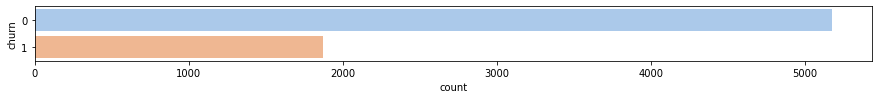

In [39]:
plt.figure(figsize=(15, 1))
sns.countplot(y='churn', palette="pastel", data=df_bin)
print(df_bin['churn'].value_counts(normalize=True))